In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow
from tensorflow.keras import models, layers, utils, backend as K

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Conv1D, MaxPooling1D, GRU, Softmax
from keras.utils import np_utils

import tensorflow_ranking as tfr

In [2]:
#Evaluation metrices that has to be used (objectives of project): accuracy, Average F1-score 
# ToDO: and Mean Average Precision (code provided on moodle) - needs to be added

# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#taken from moodle
def computeMeanAveragePrecision(labels,softmaxEstimations):

    nbExamples , nbClasses = softmaxEstimations.shape

    averagePrecisions = np.zeros((nbClasses),dtype=np.float32)

    # For all classes
    for classIdx in range(nbClasses):

        # Sort the softmaxEstimations by decreasing order, and keep the order consistent with the labels
        permutation = list(reversed(np.argsort(softmaxEstimations[:,classIdx])))
        labelArray = np.asarray(labels)
        labelsTmp = list(labelArray[permutation])

        # Convert the labels to binary (1-vs-all)
        for idx in range(len(labelsTmp)):
            if labelsTmp[idx] == classIdx:
                labelsTmp[idx] = 1
            else:
                labelsTmp[idx] = 0

        # Compute the averaged sum of precisions by descending order
        nbPrecisionComputations = 0
        averagePrecisionSum = 0

        for idx in range(len(labelsTmp)):
            if labelsTmp[idx] == 1:
                averagePrecisionSum += np.sum(labelsTmp[:idx+1])/float(idx+1)
                nbPrecisionComputations += 1

        if nbPrecisionComputations == 0:
             averagePrecisions[classIdx] = 0
        else:
            averagePrecisions[classIdx] = averagePrecisionSum/float(nbPrecisionComputations)

    # Return global MAP and class MAPs
    return np.mean(averagePrecisions), averagePrecisions



In [3]:
#labels
#LABELS = ['Standing',
#          'Sitting',
#          'Lying',
#          'Squatting',
#          'Walking',
#          'Bending']

# dictionary of labels
labeldict = {
0 : "Bring",
1 : "Clean Floor",
2 : "Clean Surface",
4 : "Close Door",
5 : "Close Drawer",
6 : "Close Lid By Rotate",
7 : "Close Other Lid",
8 : "Close Small Box",
9 : "Close Tap Water",
10 : "Drink",
11 : "Dry Off Hands",
12 : "Dry Off Hands By Shake",
13 : "Eat Small",
14 : "Gargle",
15 : "Getting Up",
16 : "Hang",
17 : "Lying Down",
18 : "Open Bag",
19 : "Open Big Box",
20 : "Open Door",
21 : "Open Drawer",
22 : "Open Lid By Rotate",
23 : "Open Other Lid",
24 : "Open Small Box",
25 : "Open Tap Water",
26 : "Plug In",
27 : "Press by Grasp",
28 : "Press From Top",
29 : "Press Switch",
30 : "Put From Bottle",
31 : "Put From Tap Water",
32 : "Put High Position",
33 : "Put On Floor",
34 : "Read",
35 : "Rotate",
36 : "Rub Hands",
37 : "Scoop And Put",
38 : "Sitting Down",
39 : "Squatting Down",
40 : "Standing Up",
41 : "Stand Up From Squatting",
42 : "Take From Floor",
43 : "Take From High Position",
44 : "Take Off Jacket",
45 : "Take Out",
46 : "Talk By Telephone",
47 : "Throw Out",
48 : "Throw Out Water",
49 : "Touch Smartphone Screen",
50 : "Type",
51 : "Unhang",
52 : "Unplug",
53 : "Wear Jacket",
54 : "Write"
}
print('done')

done


In [4]:
# load data
# training
train_acc = np.load('../data/training/trainAccelerometer.npy')
train_gra = np.load('../data/training/trainGravity.npy')
train_gyr = np.load('../data/training/trainGyroscope.npy')
train_lin = np.load('../data/training/trainLinearAcceleration.npy')

train_mag = np.load('../data/training/trainMagnetometer800.npy')

trainJins_acc = np.load('../data/training/trainJinsAccelerometer800.npy')
trainJins_gyr = np.load('../data/training/trainJinsGyroscope800.npy')

trainMS_acc = np.load('../data/training/trainMSAccelerometer800.npy')
trainMS_gyr = np.load('../data/training/trainMSGyroscope800.npy')

train_label = np.load('../data/training/trainLabels.npy')
print('loading complete')

loading complete


In [5]:
# load data
# testing
test_acc = np.load('../data/testing/testAccelerometer.npy')
test_gra = np.load('../data/testing/testGravity.npy')
test_gyr = np.load('../data/testing/testGyroscope.npy')
test_mag = np.load('../data/testing/testMagnetometer800.npy')
test_lin = np.load('../data/testing/testLinearAcceleration.npy')

testJins_acc = np.load('../data/testing/testJinsAccelerometer800.npy')
testJins_gyr = np.load('../data/testing/testJinsGyroscope800.npy')

testMS_acc = np.load('../data/testing/testMSAccelerometer800.npy')
testMS_gyr = np.load('../data/testing/testMSGyroscope800.npy')

test_label = np.load('../data/testing/testLabels.npy')
print('loading complete')

loading complete


In [12]:
# create input feature vector

# train vector:
train_data = [train_gyr, train_mag, train_lin, trainJins_acc, trainJins_gyr, trainMS_acc, trainMS_gyr]

train_features = np.append(train_acc, train_gra, axis=2)
for i in train_data:
    train_features = np.append(train_features, i, axis=2)

print('x: number of examples/executions \ny: number of samples per channel \nz: number of channels')
print('Train Features Shape: ' + str(train_features.shape))
print('Train Gyr Shape: ' + str(train_gyr.shape))

x: number of examples/executions 
y: number of samples per channel 
z: number of channels
Train Features Shape: (2284, 800, 27)
Train Gyr Shape: (2284, 800, 3)


In [13]:
# test vector:
test_data = [test_gyr, test_mag, test_lin, testJins_acc, testJins_gyr, testMS_acc, testMS_gyr]

test_features = np.append(test_acc, test_gra, axis=2)
for i in test_data:
    test_features = np.append(test_features, i, axis=2)


In [14]:
# set input and output dimensions
num_time_periods, num_sensors = train_features.shape[1], train_features.shape[2] #800, 27
num_classes = 55

# keras are not able to process multi-dimensional input data - data needs to be flattened
#  from 800x27 to 21600 values
input_shape = (num_time_periods * num_sensors)
train_features = train_features.reshape(train_features.shape[0], input_shape)

print('train_features/X_train shape:', train_features.shape)
print('input_shape:', input_shape)

train_features/X_train shape: (2284, 21600)
input_shape: 21600


In [15]:
test_features = test_features.reshape(test_features.shape[0], input_shape)

In [16]:
# numeric values can be misinterpreted by algorithms as having some sort of
# hierarchy/order in them. done with one-hot-encoding
# run only once!!!
# y_train_hot ist eine matrix, die die klassen spaltenweise beschreibt (Einheitsmatrix)
y_train_hot = np_utils.to_categorical(train_label, num_classes)
print('New y_train shape: ', y_train_hot.shape) # 55 classes -> 55 columns; 2280 rows
print(train_label.shape)
print(num_classes)

New y_train shape:  (2284, 55)
(2284,)
55


In [18]:
#training data rename
X_train = train_features
Y_train = train_label
print(X_train.shape)
print(Y_train.shape)

#test data rename
X_test = test_features
Y_test = test_label
y_test_hot = np_utils.to_categorical(test_label, num_classes)

(2284, 21600)
(2284,)


In [19]:
TIME_PERIODS = 800
# creation of model
model_4 = Sequential()
model_4.add(Reshape((TIME_PERIODS, 27), input_shape=(input_shape,)))
model_4.add(Dropout(0.1))
model_4.add(MaxPooling1D(pool_size=3)) ##
model_4.add(Conv1D(100, 20, activation='relu'))
model_4.add(MaxPooling1D(pool_size=3))
model_4.add(Dropout(0.25))
model_4.add(Conv1D(100, 20, activation='relu'))
model_4.add(MaxPooling1D(pool_size=3))
model_4.add(Dropout(0.25))
model_4.add(Conv1D(100, 20, activation='relu'))
model_4.add(Flatten())
model_4.add(Dense(55, activation='softmax'))

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 800, 27)           0         
                                                                 
 dropout (Dropout)           (None, 800, 27)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 266, 27)          0         
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 247, 100)          54100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 82, 100)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 82, 100)           0

In [20]:
# Compile the model
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.00001) #0.0001
model_4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', F1, tfr.keras.metrics.MeanAveragePrecisionMetric()])

# Train the model on the train set
BATCH_SIZE = 32
EPOCHS = 1000

history=model_4.fit(X_train, y_train_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                  validation_split=0.2, verbose=1)
score = model_4.evaluate(X_test, y_test_hot, verbose=2)
print('---------------------------------')
print(score)

Epoch 1/1000
58/58 [==============================] - 3s 25ms/step - loss: 37.1611 - accuracy: 0.0159 - F1: 0.0156 - mean_average_precision_metric: 0.0829 - val_loss: 13.3508 - val_accuracy: 0.0175 - val_F1: 0.0171 - val_mean_average_precision_metric: 0.0893
Epoch 2/1000
58/58 [==============================] - 1s 22ms/step - loss: 23.0167 - accuracy: 0.0197 - F1: 0.0183 - mean_average_precision_metric: 0.0886 - val_loss: 8.5096 - val_accuracy: 0.0263 - val_F1: 0.0168 - val_mean_average_precision_metric: 0.0961
Epoch 3/1000
58/58 [==============================] - 1s 22ms/step - loss: 15.6721 - accuracy: 0.0181 - F1: 0.0158 - mean_average_precision_metric: 0.0886 - val_loss: 6.3014 - val_accuracy: 0.0175 - val_F1: 0.0103 - val_mean_average_precision_metric: 0.0916
Epoch 4/1000
58/58 [==============================] - 1s 22ms/step - loss: 11.3718 - accuracy: 0.0197 - F1: 0.0139 - mean_average_precision_metric: 0.0897 - val_loss: 4.9553 - val_accuracy: 0.0263 - val_F1: 0.0078 - val_mean_

58/58 [==============================] - 1s 22ms/step - loss: 4.0618 - accuracy: 0.0170 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0852 - val_loss: 4.0049 - val_accuracy: 0.0109 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0766
Epoch 33/1000
58/58 [==============================] - 1s 23ms/step - loss: 4.0348 - accuracy: 0.0153 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0836 - val_loss: 4.0051 - val_accuracy: 0.0088 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0750
Epoch 34/1000
58/58 [==============================] - 1s 22ms/step - loss: 4.0371 - accuracy: 0.0186 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0879 - val_loss: 4.0053 - val_accuracy: 0.0088 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0750
Epoch 35/1000
58/58 [==============================] - 1s 22ms/step - loss: 4.0296 - accuracy: 0.0181 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0876 - val_loss: 4.0055 - val_accuracy: 0.0088 - val_F1: 0.000

Epoch 63/1000
58/58 [==============================] - 1s 22ms/step - loss: 4.0177 - accuracy: 0.0192 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0913 - val_loss: 4.0067 - val_accuracy: 0.0066 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0677
Epoch 64/1000
58/58 [==============================] - 1s 23ms/step - loss: 4.0031 - accuracy: 0.0186 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0901 - val_loss: 4.0067 - val_accuracy: 0.0066 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0677
Epoch 65/1000
58/58 [==============================] - 1s 22ms/step - loss: 4.0091 - accuracy: 0.0164 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0899 - val_loss: 4.0068 - val_accuracy: 0.0066 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0679
Epoch 66/1000
58/58 [==============================] - 1s 22ms/step - loss: 4.0112 - accuracy: 0.0192 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0910 - val_loss: 4.0068 - val_accuracy: 0.0066 -

Epoch 94/1000
58/58 [==============================] - 1s 23ms/step - loss: 3.9968 - accuracy: 0.0246 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0972 - val_loss: 4.0016 - val_accuracy: 0.0197 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0766
Epoch 95/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.9972 - accuracy: 0.0279 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0989 - val_loss: 4.0021 - val_accuracy: 0.0153 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0744
Epoch 96/1000
58/58 [==============================] - 1s 22ms/step - loss: 4.0019 - accuracy: 0.0263 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0965 - val_loss: 4.0019 - val_accuracy: 0.0153 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0744
Epoch 97/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.9857 - accuracy: 0.0263 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0996 - val_loss: 3.9981 - val_accuracy: 0.0197 -

58/58 [==============================] - 1s 23ms/step - loss: 3.8979 - accuracy: 0.0531 - F1: 0.0308 - mean_average_precision_metric: 0.1271 - val_loss: 3.9437 - val_accuracy: 0.0306 - val_F1: 0.0200 - val_mean_average_precision_metric: 0.0902
Epoch 126/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.9096 - accuracy: 0.0553 - F1: 0.0287 - mean_average_precision_metric: 0.1303 - val_loss: 3.9397 - val_accuracy: 0.0306 - val_F1: 0.0240 - val_mean_average_precision_metric: 0.0907
Epoch 127/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.9017 - accuracy: 0.0520 - F1: 0.0312 - mean_average_precision_metric: 0.1265 - val_loss: 3.9374 - val_accuracy: 0.0306 - val_F1: 0.0240 - val_mean_average_precision_metric: 0.0913
Epoch 128/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.9080 - accuracy: 0.0520 - F1: 0.0247 - mean_average_precision_metric: 0.1257 - val_loss: 3.9412 - val_accuracy: 0.0306 - val_F1: 0.0200 - val_mean_average_prec

Epoch 157/1000
58/58 [==============================] - 1s 23ms/step - loss: 3.7767 - accuracy: 0.0816 - F1: 0.0538 - mean_average_precision_metric: 0.1628 - val_loss: 3.8759 - val_accuracy: 0.0438 - val_F1: 0.0279 - val_mean_average_precision_metric: 0.1139
Epoch 158/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.7672 - accuracy: 0.0799 - F1: 0.0588 - mean_average_precision_metric: 0.1645 - val_loss: 3.8744 - val_accuracy: 0.0438 - val_F1: 0.0279 - val_mean_average_precision_metric: 0.1130
Epoch 159/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.7924 - accuracy: 0.0755 - F1: 0.0676 - mean_average_precision_metric: 0.1593 - val_loss: 3.8742 - val_accuracy: 0.0438 - val_F1: 0.0279 - val_mean_average_precision_metric: 0.1136
Epoch 160/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.7652 - accuracy: 0.0810 - F1: 0.0644 - mean_average_precision_metric: 0.1652 - val_loss: 3.8760 - val_accuracy: 0.0438 - val_F1: 0.0279 - val_me

Epoch 189/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.5593 - accuracy: 0.1292 - F1: 0.1056 - mean_average_precision_metric: 0.2242 - val_loss: 3.7538 - val_accuracy: 0.0788 - val_F1: 0.0390 - val_mean_average_precision_metric: 0.1669
Epoch 190/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.5480 - accuracy: 0.1341 - F1: 0.1085 - mean_average_precision_metric: 0.2263 - val_loss: 3.7321 - val_accuracy: 0.0832 - val_F1: 0.0471 - val_mean_average_precision_metric: 0.1773
Epoch 191/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.5258 - accuracy: 0.1374 - F1: 0.1085 - mean_average_precision_metric: 0.2302 - val_loss: 3.7221 - val_accuracy: 0.0919 - val_F1: 0.0508 - val_mean_average_precision_metric: 0.1853
Epoch 192/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.5298 - accuracy: 0.1401 - F1: 0.1186 - mean_average_precision_metric: 0.2318 - val_loss: 3.7157 - val_accuracy: 0.0897 - val_F1: 0.0508 - val_me

Epoch 221/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.1688 - accuracy: 0.1992 - F1: 0.1901 - mean_average_precision_metric: 0.3087 - val_loss: 3.4258 - val_accuracy: 0.1597 - val_F1: 0.1107 - val_mean_average_precision_metric: 0.2686
Epoch 222/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.1713 - accuracy: 0.2069 - F1: 0.1975 - mean_average_precision_metric: 0.3138 - val_loss: 3.4122 - val_accuracy: 0.1707 - val_F1: 0.1177 - val_mean_average_precision_metric: 0.2801
Epoch 223/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.1908 - accuracy: 0.2124 - F1: 0.1994 - mean_average_precision_metric: 0.3169 - val_loss: 3.3998 - val_accuracy: 0.1729 - val_F1: 0.1142 - val_mean_average_precision_metric: 0.2794
Epoch 224/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.0860 - accuracy: 0.2299 - F1: 0.2142 - mean_average_precision_metric: 0.3377 - val_loss: 3.3854 - val_accuracy: 0.1707 - val_F1: 0.1178 - val_me

Epoch 253/1000
58/58 [==============================] - 1s 22ms/step - loss: 2.6510 - accuracy: 0.3328 - F1: 0.3368 - mean_average_precision_metric: 0.4447 - val_loss: 3.0117 - val_accuracy: 0.2735 - val_F1: 0.2191 - val_mean_average_precision_metric: 0.3877
Epoch 254/1000
58/58 [==============================] - 1s 21ms/step - loss: 2.6141 - accuracy: 0.3322 - F1: 0.3116 - mean_average_precision_metric: 0.4510 - val_loss: 2.9999 - val_accuracy: 0.2801 - val_F1: 0.2323 - val_mean_average_precision_metric: 0.3926
Epoch 255/1000
58/58 [==============================] - 1s 22ms/step - loss: 2.5989 - accuracy: 0.3404 - F1: 0.3391 - mean_average_precision_metric: 0.4566 - val_loss: 2.9822 - val_accuracy: 0.2735 - val_F1: 0.2288 - val_mean_average_precision_metric: 0.3924
Epoch 256/1000
58/58 [==============================] - 1s 22ms/step - loss: 2.5802 - accuracy: 0.3421 - F1: 0.3494 - mean_average_precision_metric: 0.4580 - val_loss: 2.9694 - val_accuracy: 0.2670 - val_F1: 0.2293 - val_me

Epoch 285/1000
58/58 [==============================] - 1s 21ms/step - loss: 2.1265 - accuracy: 0.4428 - F1: 0.4374 - mean_average_precision_metric: 0.5579 - val_loss: 2.6557 - val_accuracy: 0.3698 - val_F1: 0.3214 - val_mean_average_precision_metric: 0.4771
Epoch 286/1000
58/58 [==============================] - 1s 21ms/step - loss: 2.1669 - accuracy: 0.4269 - F1: 0.4335 - mean_average_precision_metric: 0.5469 - val_loss: 2.6455 - val_accuracy: 0.3807 - val_F1: 0.3235 - val_mean_average_precision_metric: 0.4844
Epoch 287/1000
58/58 [==============================] - 1s 21ms/step - loss: 2.1272 - accuracy: 0.4357 - F1: 0.4361 - mean_average_precision_metric: 0.5544 - val_loss: 2.6377 - val_accuracy: 0.3829 - val_F1: 0.3167 - val_mean_average_precision_metric: 0.4890
Epoch 288/1000
58/58 [==============================] - 1s 21ms/step - loss: 2.0945 - accuracy: 0.4346 - F1: 0.4477 - mean_average_precision_metric: 0.5568 - val_loss: 2.6207 - val_accuracy: 0.3786 - val_F1: 0.3236 - val_me

Epoch 317/1000
58/58 [==============================] - 1s 21ms/step - loss: 1.7329 - accuracy: 0.5282 - F1: 0.5329 - mean_average_precision_metric: 0.6374 - val_loss: 2.3554 - val_accuracy: 0.4289 - val_F1: 0.3746 - val_mean_average_precision_metric: 0.5451
Epoch 318/1000
58/58 [==============================] - 1s 21ms/step - loss: 1.7574 - accuracy: 0.5326 - F1: 0.5308 - mean_average_precision_metric: 0.6414 - val_loss: 2.3588 - val_accuracy: 0.4311 - val_F1: 0.3835 - val_mean_average_precision_metric: 0.5453
Epoch 319/1000
58/58 [==============================] - 1s 21ms/step - loss: 1.7520 - accuracy: 0.5430 - F1: 0.5375 - mean_average_precision_metric: 0.6463 - val_loss: 2.3500 - val_accuracy: 0.4354 - val_F1: 0.3825 - val_mean_average_precision_metric: 0.5474
Epoch 320/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.7202 - accuracy: 0.5271 - F1: 0.5459 - mean_average_precision_metric: 0.6393 - val_loss: 2.3392 - val_accuracy: 0.4311 - val_F1: 0.3812 - val_me

Epoch 349/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.3668 - accuracy: 0.6218 - F1: 0.6252 - mean_average_precision_metric: 0.7219 - val_loss: 2.1568 - val_accuracy: 0.4770 - val_F1: 0.4338 - val_mean_average_precision_metric: 0.5904
Epoch 350/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.3761 - accuracy: 0.6097 - F1: 0.6331 - mean_average_precision_metric: 0.7144 - val_loss: 2.1372 - val_accuracy: 0.4945 - val_F1: 0.4403 - val_mean_average_precision_metric: 0.6018
Epoch 351/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.3787 - accuracy: 0.6267 - F1: 0.6332 - mean_average_precision_metric: 0.7230 - val_loss: 2.1225 - val_accuracy: 0.4923 - val_F1: 0.4434 - val_mean_average_precision_metric: 0.6019
Epoch 352/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.3547 - accuracy: 0.6229 - F1: 0.6283 - mean_average_precision_metric: 0.7224 - val_loss: 2.1081 - val_accuracy: 0.5011 - val_F1: 0.4425 - val_me

Epoch 381/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.0488 - accuracy: 0.7050 - F1: 0.7187 - mean_average_precision_metric: 0.7918 - val_loss: 1.9705 - val_accuracy: 0.5252 - val_F1: 0.4899 - val_mean_average_precision_metric: 0.6367
Epoch 382/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.0584 - accuracy: 0.6946 - F1: 0.6919 - mean_average_precision_metric: 0.7887 - val_loss: 1.9607 - val_accuracy: 0.5274 - val_F1: 0.5084 - val_mean_average_precision_metric: 0.6357
Epoch 383/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.0315 - accuracy: 0.7137 - F1: 0.7071 - mean_average_precision_metric: 0.7973 - val_loss: 1.9493 - val_accuracy: 0.5339 - val_F1: 0.4949 - val_mean_average_precision_metric: 0.6415
Epoch 384/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.0185 - accuracy: 0.7099 - F1: 0.7190 - mean_average_precision_metric: 0.7984 - val_loss: 1.9538 - val_accuracy: 0.5405 - val_F1: 0.4986 - val_me

Epoch 413/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.7908 - accuracy: 0.7668 - F1: 0.7689 - mean_average_precision_metric: 0.8422 - val_loss: 1.8358 - val_accuracy: 0.5602 - val_F1: 0.5420 - val_mean_average_precision_metric: 0.6693
Epoch 414/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.7712 - accuracy: 0.7865 - F1: 0.7819 - mean_average_precision_metric: 0.8535 - val_loss: 1.8379 - val_accuracy: 0.5602 - val_F1: 0.5474 - val_mean_average_precision_metric: 0.6687
Epoch 415/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.7668 - accuracy: 0.7811 - F1: 0.7735 - mean_average_precision_metric: 0.8531 - val_loss: 1.8273 - val_accuracy: 0.5646 - val_F1: 0.5541 - val_mean_average_precision_metric: 0.6699
Epoch 416/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.7777 - accuracy: 0.7712 - F1: 0.7712 - mean_average_precision_metric: 0.8451 - val_loss: 1.8038 - val_accuracy: 0.5777 - val_F1: 0.5639 - val_me

Epoch 445/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.5722 - accuracy: 0.8369 - F1: 0.8407 - mean_average_precision_metric: 0.8922 - val_loss: 1.7723 - val_accuracy: 0.5799 - val_F1: 0.5857 - val_mean_average_precision_metric: 0.6898
Epoch 446/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.5705 - accuracy: 0.8363 - F1: 0.8414 - mean_average_precision_metric: 0.8938 - val_loss: 1.7560 - val_accuracy: 0.5886 - val_F1: 0.5822 - val_mean_average_precision_metric: 0.6943
Epoch 447/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.5749 - accuracy: 0.8292 - F1: 0.8311 - mean_average_precision_metric: 0.8890 - val_loss: 1.7504 - val_accuracy: 0.5952 - val_F1: 0.5918 - val_mean_average_precision_metric: 0.7003
Epoch 448/1000
58/58 [==============================] - 1s 21ms/step - loss: 0.5882 - accuracy: 0.8243 - F1: 0.8339 - mean_average_precision_metric: 0.8864 - val_loss: 1.7729 - val_accuracy: 0.5842 - val_F1: 0.5802 - val_me

Epoch 477/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.4315 - accuracy: 0.8725 - F1: 0.8736 - mean_average_precision_metric: 0.9202 - val_loss: 1.7513 - val_accuracy: 0.6039 - val_F1: 0.5907 - val_mean_average_precision_metric: 0.7091
Epoch 478/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.4174 - accuracy: 0.8736 - F1: 0.8767 - mean_average_precision_metric: 0.9215 - val_loss: 1.7508 - val_accuracy: 0.5930 - val_F1: 0.5952 - val_mean_average_precision_metric: 0.7039
Epoch 479/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.4072 - accuracy: 0.8823 - F1: 0.8844 - mean_average_precision_metric: 0.9262 - val_loss: 1.7410 - val_accuracy: 0.6127 - val_F1: 0.6088 - val_mean_average_precision_metric: 0.7144
Epoch 480/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.4306 - accuracy: 0.8845 - F1: 0.8742 - mean_average_precision_metric: 0.9270 - val_loss: 1.7584 - val_accuracy: 0.6105 - val_F1: 0.5965 - val_me

Epoch 509/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.3334 - accuracy: 0.9009 - F1: 0.9006 - mean_average_precision_metric: 0.9379 - val_loss: 1.7149 - val_accuracy: 0.6258 - val_F1: 0.6228 - val_mean_average_precision_metric: 0.7256
Epoch 510/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.3232 - accuracy: 0.9070 - F1: 0.9088 - mean_average_precision_metric: 0.9424 - val_loss: 1.7137 - val_accuracy: 0.6258 - val_F1: 0.6167 - val_mean_average_precision_metric: 0.7259
Epoch 511/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.3033 - accuracy: 0.9053 - F1: 0.9072 - mean_average_precision_metric: 0.9432 - val_loss: 1.7194 - val_accuracy: 0.6193 - val_F1: 0.6154 - val_mean_average_precision_metric: 0.7230
Epoch 512/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.3045 - accuracy: 0.9146 - F1: 0.9109 - mean_average_precision_metric: 0.9479 - val_loss: 1.7184 - val_accuracy: 0.6258 - val_F1: 0.6159 - val_me

Epoch 541/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.2344 - accuracy: 0.9299 - F1: 0.9303 - mean_average_precision_metric: 0.9582 - val_loss: 1.7874 - val_accuracy: 0.6127 - val_F1: 0.6288 - val_mean_average_precision_metric: 0.7206
Epoch 542/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.2300 - accuracy: 0.9288 - F1: 0.9279 - mean_average_precision_metric: 0.9577 - val_loss: 1.7664 - val_accuracy: 0.6105 - val_F1: 0.6259 - val_mean_average_precision_metric: 0.7214
Epoch 543/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.2495 - accuracy: 0.9223 - F1: 0.9180 - mean_average_precision_metric: 0.9548 - val_loss: 1.7589 - val_accuracy: 0.6258 - val_F1: 0.6396 - val_mean_average_precision_metric: 0.7307
Epoch 544/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.2226 - accuracy: 0.9332 - F1: 0.9329 - mean_average_precision_metric: 0.9600 - val_loss: 1.7643 - val_accuracy: 0.6171 - val_F1: 0.6337 - val_me

Epoch 573/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1815 - accuracy: 0.9409 - F1: 0.9412 - mean_average_precision_metric: 0.9659 - val_loss: 1.7362 - val_accuracy: 0.6389 - val_F1: 0.6386 - val_mean_average_precision_metric: 0.7417
Epoch 574/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1802 - accuracy: 0.9458 - F1: 0.9456 - mean_average_precision_metric: 0.9683 - val_loss: 1.7408 - val_accuracy: 0.6346 - val_F1: 0.6403 - val_mean_average_precision_metric: 0.7403
Epoch 575/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1781 - accuracy: 0.9447 - F1: 0.9451 - mean_average_precision_metric: 0.9691 - val_loss: 1.7722 - val_accuracy: 0.6346 - val_F1: 0.6399 - val_mean_average_precision_metric: 0.7387
Epoch 576/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1802 - accuracy: 0.9502 - F1: 0.9488 - mean_average_precision_metric: 0.9714 - val_loss: 1.8027 - val_accuracy: 0.6302 - val_F1: 0.6443 - val_me

Epoch 605/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1412 - accuracy: 0.9568 - F1: 0.9565 - mean_average_precision_metric: 0.9763 - val_loss: 1.7563 - val_accuracy: 0.6433 - val_F1: 0.6524 - val_mean_average_precision_metric: 0.7483
Epoch 606/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1467 - accuracy: 0.9595 - F1: 0.9593 - mean_average_precision_metric: 0.9775 - val_loss: 1.7720 - val_accuracy: 0.6324 - val_F1: 0.6541 - val_mean_average_precision_metric: 0.7442
Epoch 607/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1450 - accuracy: 0.9551 - F1: 0.9548 - mean_average_precision_metric: 0.9750 - val_loss: 1.7584 - val_accuracy: 0.6433 - val_F1: 0.6489 - val_mean_average_precision_metric: 0.7473
Epoch 608/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1203 - accuracy: 0.9639 - F1: 0.9667 - mean_average_precision_metric: 0.9794 - val_loss: 1.7748 - val_accuracy: 0.6389 - val_F1: 0.6431 - val_me

Epoch 637/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1082 - accuracy: 0.9704 - F1: 0.9694 - mean_average_precision_metric: 0.9841 - val_loss: 1.8127 - val_accuracy: 0.6477 - val_F1: 0.6564 - val_mean_average_precision_metric: 0.7498
Epoch 638/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1035 - accuracy: 0.9672 - F1: 0.9692 - mean_average_precision_metric: 0.9824 - val_loss: 1.8359 - val_accuracy: 0.6477 - val_F1: 0.6517 - val_mean_average_precision_metric: 0.7479
Epoch 639/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0984 - accuracy: 0.9721 - F1: 0.9708 - mean_average_precision_metric: 0.9846 - val_loss: 1.7926 - val_accuracy: 0.6499 - val_F1: 0.6607 - val_mean_average_precision_metric: 0.7525
Epoch 640/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1038 - accuracy: 0.9688 - F1: 0.9665 - mean_average_precision_metric: 0.9835 - val_loss: 1.8025 - val_accuracy: 0.6455 - val_F1: 0.6550 - val_me

Epoch 669/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0659 - accuracy: 0.9858 - F1: 0.9847 - mean_average_precision_metric: 0.9921 - val_loss: 1.8591 - val_accuracy: 0.6565 - val_F1: 0.6618 - val_mean_average_precision_metric: 0.7539
Epoch 670/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0838 - accuracy: 0.9776 - F1: 0.9768 - mean_average_precision_metric: 0.9878 - val_loss: 1.8530 - val_accuracy: 0.6455 - val_F1: 0.6572 - val_mean_average_precision_metric: 0.7495
Epoch 671/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0908 - accuracy: 0.9732 - F1: 0.9714 - mean_average_precision_metric: 0.9855 - val_loss: 1.8627 - val_accuracy: 0.6521 - val_F1: 0.6617 - val_mean_average_precision_metric: 0.7533
Epoch 672/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0806 - accuracy: 0.9732 - F1: 0.9725 - mean_average_precision_metric: 0.9859 - val_loss: 1.8483 - val_accuracy: 0.6565 - val_F1: 0.6767 - val_me

Epoch 701/1000
58/58 [==============================] - 1s 24ms/step - loss: 0.0634 - accuracy: 0.9847 - F1: 0.9815 - mean_average_precision_metric: 0.9919 - val_loss: 1.8646 - val_accuracy: 0.6586 - val_F1: 0.6686 - val_mean_average_precision_metric: 0.7580
Epoch 702/1000
58/58 [==============================] - 1s 24ms/step - loss: 0.0604 - accuracy: 0.9825 - F1: 0.9835 - mean_average_precision_metric: 0.9908 - val_loss: 1.9048 - val_accuracy: 0.6565 - val_F1: 0.6723 - val_mean_average_precision_metric: 0.7559
Epoch 703/1000
58/58 [==============================] - 1s 23ms/step - loss: 0.0697 - accuracy: 0.9803 - F1: 0.9807 - mean_average_precision_metric: 0.9896 - val_loss: 1.8717 - val_accuracy: 0.6652 - val_F1: 0.6775 - val_mean_average_precision_metric: 0.7595
Epoch 704/1000
58/58 [==============================] - 1s 23ms/step - loss: 0.0518 - accuracy: 0.9891 - F1: 0.9884 - mean_average_precision_metric: 0.9938 - val_loss: 1.9020 - val_accuracy: 0.6696 - val_F1: 0.6783 - val_me

Epoch 733/1000
58/58 [==============================] - 1s 23ms/step - loss: 0.0441 - accuracy: 0.9874 - F1: 0.9867 - mean_average_precision_metric: 0.9936 - val_loss: 1.9519 - val_accuracy: 0.6543 - val_F1: 0.6655 - val_mean_average_precision_metric: 0.7539
Epoch 734/1000
58/58 [==============================] - 1s 24ms/step - loss: 0.0553 - accuracy: 0.9830 - F1: 0.9833 - mean_average_precision_metric: 0.9912 - val_loss: 1.9517 - val_accuracy: 0.6586 - val_F1: 0.6669 - val_mean_average_precision_metric: 0.7572
Epoch 735/1000
58/58 [==============================] - 1s 25ms/step - loss: 0.0537 - accuracy: 0.9830 - F1: 0.9834 - mean_average_precision_metric: 0.9911 - val_loss: 1.9082 - val_accuracy: 0.6630 - val_F1: 0.6773 - val_mean_average_precision_metric: 0.7604
Epoch 736/1000
58/58 [==============================] - 1s 23ms/step - loss: 0.0575 - accuracy: 0.9808 - F1: 0.9808 - mean_average_precision_metric: 0.9904 - val_loss: 1.9574 - val_accuracy: 0.6543 - val_F1: 0.6700 - val_me

Epoch 765/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0374 - accuracy: 0.9896 - F1: 0.9894 - mean_average_precision_metric: 0.9945 - val_loss: 1.9711 - val_accuracy: 0.6586 - val_F1: 0.6706 - val_mean_average_precision_metric: 0.7566
Epoch 766/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0453 - accuracy: 0.9869 - F1: 0.9883 - mean_average_precision_metric: 0.9932 - val_loss: 1.9736 - val_accuracy: 0.6565 - val_F1: 0.6679 - val_mean_average_precision_metric: 0.7549
Epoch 767/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0430 - accuracy: 0.9880 - F1: 0.9884 - mean_average_precision_metric: 0.9938 - val_loss: 1.9582 - val_accuracy: 0.6586 - val_F1: 0.6685 - val_mean_average_precision_metric: 0.7570
Epoch 768/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0359 - accuracy: 0.9907 - F1: 0.9905 - mean_average_precision_metric: 0.9953 - val_loss: 1.9775 - val_accuracy: 0.6652 - val_F1: 0.6665 - val_me

Epoch 797/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0346 - accuracy: 0.9934 - F1: 0.9910 - mean_average_precision_metric: 0.9966 - val_loss: 2.0018 - val_accuracy: 0.6543 - val_F1: 0.6700 - val_mean_average_precision_metric: 0.7544
Epoch 798/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0394 - accuracy: 0.9885 - F1: 0.9873 - mean_average_precision_metric: 0.9943 - val_loss: 1.9629 - val_accuracy: 0.6586 - val_F1: 0.6710 - val_mean_average_precision_metric: 0.7568
Epoch 799/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0299 - accuracy: 0.9929 - F1: 0.9921 - mean_average_precision_metric: 0.9964 - val_loss: 1.9791 - val_accuracy: 0.6674 - val_F1: 0.6708 - val_mean_average_precision_metric: 0.7625
Epoch 800/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0308 - accuracy: 0.9923 - F1: 0.9927 - mean_average_precision_metric: 0.9961 - val_loss: 1.9865 - val_accuracy: 0.6783 - val_F1: 0.6822 - val_me

Epoch 829/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0196 - accuracy: 0.9962 - F1: 0.9960 - mean_average_precision_metric: 0.9981 - val_loss: 2.0378 - val_accuracy: 0.6718 - val_F1: 0.6895 - val_mean_average_precision_metric: 0.7629
Epoch 830/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0306 - accuracy: 0.9912 - F1: 0.9903 - mean_average_precision_metric: 0.9955 - val_loss: 2.0144 - val_accuracy: 0.6696 - val_F1: 0.6800 - val_mean_average_precision_metric: 0.7612
Epoch 831/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0277 - accuracy: 0.9918 - F1: 0.9913 - mean_average_precision_metric: 0.9959 - val_loss: 2.0088 - val_accuracy: 0.6718 - val_F1: 0.6749 - val_mean_average_precision_metric: 0.7630
Epoch 832/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0334 - accuracy: 0.9907 - F1: 0.9903 - mean_average_precision_metric: 0.9953 - val_loss: 2.0039 - val_accuracy: 0.6740 - val_F1: 0.6816 - val_me

Epoch 861/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0223 - accuracy: 0.9945 - F1: 0.9943 - mean_average_precision_metric: 0.9973 - val_loss: 2.1376 - val_accuracy: 0.6630 - val_F1: 0.6814 - val_mean_average_precision_metric: 0.7577
Epoch 862/1000
58/58 [==============================] - 1s 23ms/step - loss: 0.0259 - accuracy: 0.9934 - F1: 0.9930 - mean_average_precision_metric: 0.9967 - val_loss: 2.1624 - val_accuracy: 0.6586 - val_F1: 0.6674 - val_mean_average_precision_metric: 0.7551
Epoch 863/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0198 - accuracy: 0.9951 - F1: 0.9949 - mean_average_precision_metric: 0.9974 - val_loss: 2.0897 - val_accuracy: 0.6761 - val_F1: 0.6867 - val_mean_average_precision_metric: 0.7646
Epoch 864/1000
58/58 [==============================] - 1s 23ms/step - loss: 0.0313 - accuracy: 0.9934 - F1: 0.9932 - mean_average_precision_metric: 0.9967 - val_loss: 2.0786 - val_accuracy: 0.6783 - val_F1: 0.6880 - val_me

Epoch 893/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0229 - accuracy: 0.9951 - F1: 0.9951 - mean_average_precision_metric: 0.9975 - val_loss: 2.1076 - val_accuracy: 0.6630 - val_F1: 0.6811 - val_mean_average_precision_metric: 0.7595
Epoch 894/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0179 - accuracy: 0.9945 - F1: 0.9946 - mean_average_precision_metric: 0.9973 - val_loss: 2.0688 - val_accuracy: 0.6871 - val_F1: 0.7031 - val_mean_average_precision_metric: 0.7732
Epoch 895/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0226 - accuracy: 0.9934 - F1: 0.9935 - mean_average_precision_metric: 0.9967 - val_loss: 2.1082 - val_accuracy: 0.6696 - val_F1: 0.6927 - val_mean_average_precision_metric: 0.7650
Epoch 896/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0200 - accuracy: 0.9951 - F1: 0.9957 - mean_average_precision_metric: 0.9972 - val_loss: 2.0878 - val_accuracy: 0.6783 - val_F1: 0.6852 - val_me

Epoch 925/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0192 - accuracy: 0.9962 - F1: 0.9962 - mean_average_precision_metric: 0.9981 - val_loss: 2.1455 - val_accuracy: 0.6783 - val_F1: 0.6883 - val_mean_average_precision_metric: 0.7658
Epoch 926/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0191 - accuracy: 0.9929 - F1: 0.9930 - mean_average_precision_metric: 0.9964 - val_loss: 2.1887 - val_accuracy: 0.6740 - val_F1: 0.6791 - val_mean_average_precision_metric: 0.7641
Epoch 927/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0247 - accuracy: 0.9929 - F1: 0.9875 - mean_average_precision_metric: 0.9964 - val_loss: 2.1682 - val_accuracy: 0.6630 - val_F1: 0.6848 - val_mean_average_precision_metric: 0.7586
Epoch 928/1000
58/58 [==============================] - 1s 23ms/step - loss: 0.0329 - accuracy: 0.9907 - F1: 0.9905 - mean_average_precision_metric: 0.9953 - val_loss: 2.1816 - val_accuracy: 0.6696 - val_F1: 0.6848 - val_me

Epoch 957/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0172 - accuracy: 0.9951 - F1: 0.9949 - mean_average_precision_metric: 0.9975 - val_loss: 2.2356 - val_accuracy: 0.6630 - val_F1: 0.6729 - val_mean_average_precision_metric: 0.7583
Epoch 958/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0147 - accuracy: 0.9967 - F1: 0.9968 - mean_average_precision_metric: 0.9982 - val_loss: 2.2779 - val_accuracy: 0.6521 - val_F1: 0.6651 - val_mean_average_precision_metric: 0.7524
Epoch 959/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0149 - accuracy: 0.9967 - F1: 0.9965 - mean_average_precision_metric: 0.9984 - val_loss: 2.2661 - val_accuracy: 0.6565 - val_F1: 0.6686 - val_mean_average_precision_metric: 0.7541
Epoch 960/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0250 - accuracy: 0.9934 - F1: 0.9938 - mean_average_precision_metric: 0.9966 - val_loss: 2.2552 - val_accuracy: 0.6630 - val_F1: 0.6804 - val_me

Epoch 989/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0117 - accuracy: 0.9956 - F1: 0.9957 - mean_average_precision_metric: 0.9978 - val_loss: 2.2108 - val_accuracy: 0.6783 - val_F1: 0.6854 - val_mean_average_precision_metric: 0.7689
Epoch 990/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0123 - accuracy: 0.9967 - F1: 0.9967 - mean_average_precision_metric: 0.9983 - val_loss: 2.1942 - val_accuracy: 0.6783 - val_F1: 0.6835 - val_mean_average_precision_metric: 0.7691
Epoch 991/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0124 - accuracy: 0.9973 - F1: 0.9976 - mean_average_precision_metric: 0.9984 - val_loss: 2.2155 - val_accuracy: 0.6761 - val_F1: 0.6792 - val_mean_average_precision_metric: 0.7686
Epoch 992/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0122 - accuracy: 0.9978 - F1: 0.9976 - mean_average_precision_metric: 0.9989 - val_loss: 2.2150 - val_accuracy: 0.6718 - val_F1: 0.6777 - val_me

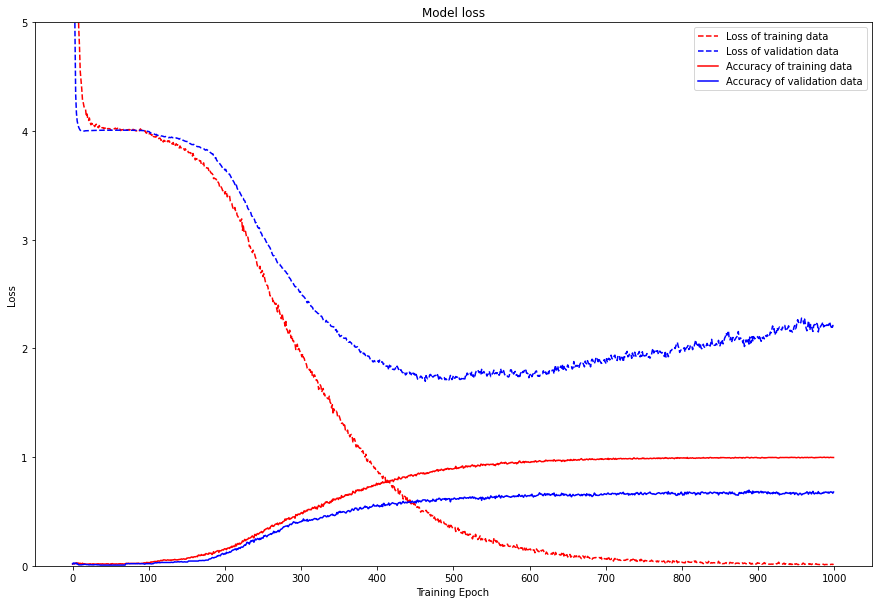

In [21]:
plt.figure(figsize=(15, 10))

plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')


plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.xticks(range(0, 1001, 100))
plt.yticks(range(0, 6))
plt.ylim(0,5)
plt.legend()
plt.show()

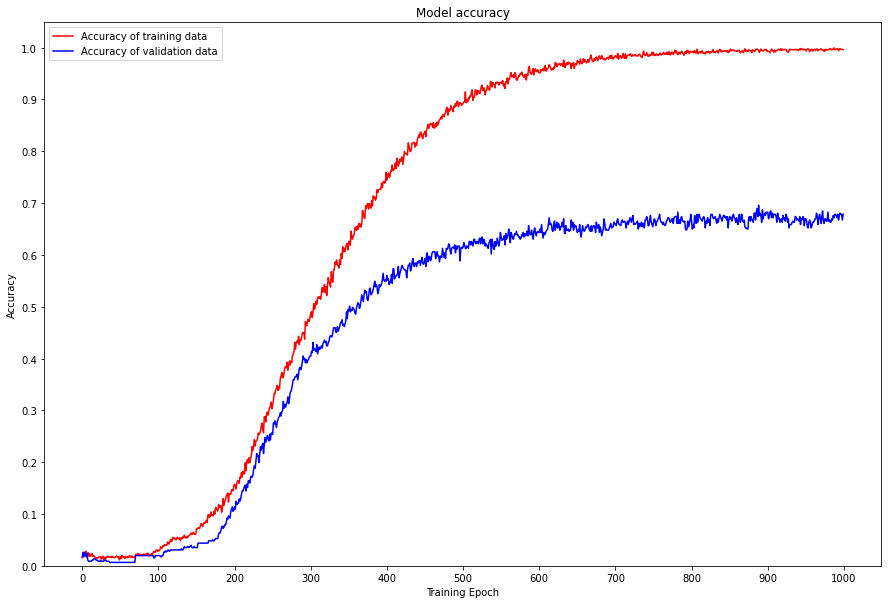

In [22]:
plt.figure(figsize=(15, 10))

plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.xticks(range(0, 1001, 100))
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.ylim(0)
plt.legend()
plt.show()

In [23]:
# Print confusion matrix for training data
y_pred_train = model_4.predict(train_features)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(train_label.shape, max_y_pred_train.shape, train_features.shape)
print(classification_report(train_label, max_y_pred_train))

(2284,) (2284,) (2284, 21600)
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        41
           1       0.95      0.95      0.95        42
           2       0.90      0.88      0.89        43
           3       0.91      0.93      0.92        42
           4       0.98      0.85      0.91        48
           5       0.95      0.83      0.89        42
           6       0.97      0.86      0.91        42
           7       0.95      0.91      0.93        46
           8       0.95      0.87      0.91        47
           9       0.82      0.70      0.76        20
          10       0.85      0.98      0.91        45
          11       1.00      0.93      0.96        41
          12       0.95      0.97      0.96        40
          13       0.93      0.97      0.95        40
          14       1.00      0.97      0.99        40
          15       1.00      1.00      1.00        42
          16       0.87      0.85      0.86        

In [24]:
model_4.save('model_4.x1000.00001')

INFO:tensorflow:Assets written to: model_4.x1000.00001\assets


I think the effect of increasing loss and accuracy is caused by a network that, at a given epoch, might be severely overfit on some classes but still learning on others.

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model_4, to_file='model_4_1000epoch_00001lr_55valaccuracy.png', dpi=100, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


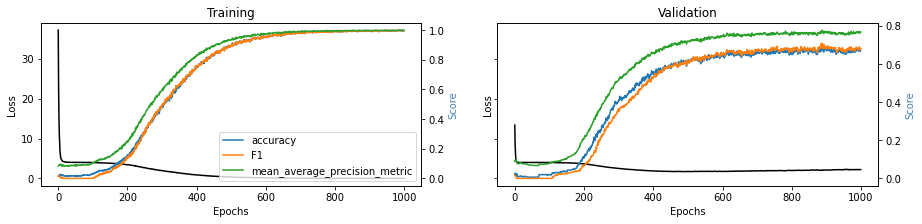

In [26]:
# plot
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))

## training
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(history.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(history.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

## validation
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(history.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
    ax22.plot(history.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
plt.show()